In [62]:
from datasets import load_dataset
import matplotlib.pyplot as plt
from PIL import Image
import datasets
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torchvision.models as models
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import random
import nibabel as nib

In [ ]:
ds = load_dataset("SofiaVouzika/Liver_Tumor")

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4236
    })
})

In [14]:
def show_samples(dataset, num_samples=5):
    for i in range(num_samples):
        # Извлечение изображения и метки
        image = dataset['train'][i]['image']
        label = dataset['train'][i]['label']
        
        # Отображение изображения
        plt.imshow(image)
        plt.title(f'Label: {label}')
        plt.axis('off')
        plt.show()

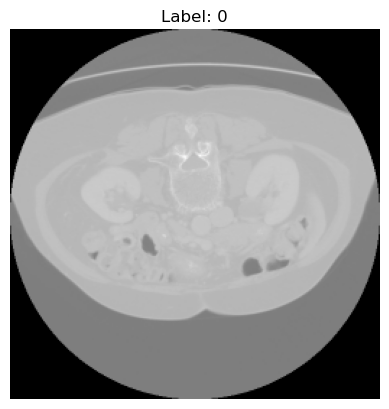

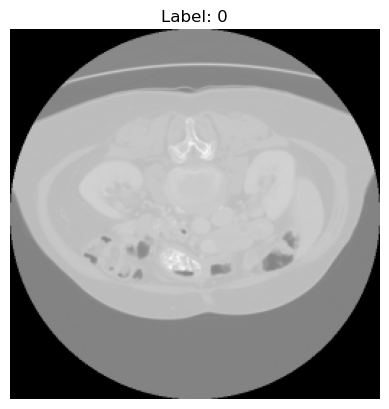

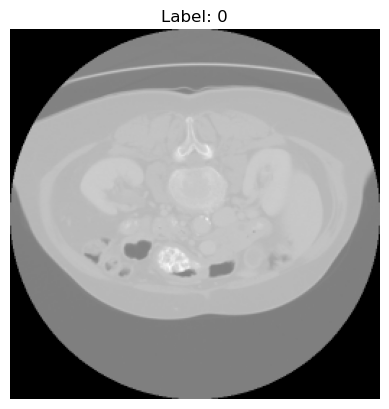

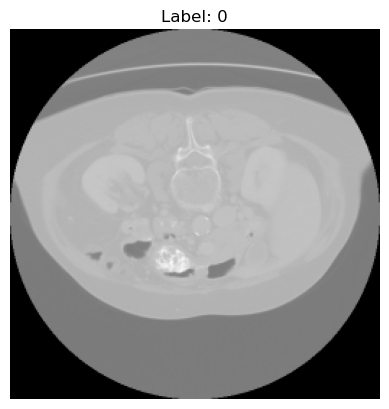

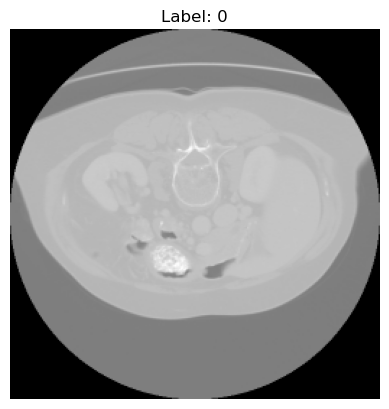

In [15]:
show_samples(ds)

In [16]:
local_dir = r"C:\Users\dania\OneDrive\Рабочий стол\liver"

ds.save_to_disk(local_dir)

Saving the dataset (0/1 shards):   0%|          | 0/4236 [00:00<?, ? examples/s]

In [18]:
dt = datasets.load_from_disk(local_dir)

In [19]:
dt

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4236
    })
})

In [21]:
sample_rows = ds['train'].select(range(5))

In [23]:
sample_rows[0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=256x256>,
 'label': 0}

In [25]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [26]:
transform = transforms.Compose([
    transforms.Resize((256, 256)),  
    transforms.ToTensor(),
])

In [27]:
images = [example['image'] for example in ds['train']]
labels = [example['label'] for example in ds['train']]

In [32]:
len(images), len(labels)

(4236, 4236)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [34]:
train_dataset = CustomDataset(X_train, y_train, transform=transform)
test_dataset = CustomDataset(X_test, y_test, transform=transform)

In [35]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [40]:
class TumorModel(nn.Module):
    def __init__(self):
        super(TumorModel, self).__init__()
        self.resnet = models.resnet18(pretrained=True)  # |ResNet-18
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 2)  # tumor or not

    def forward(self, x):
        return self.resnet(x)

In [41]:
def train_model(model, train_loader, criterion, optimizer, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

In [42]:
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print(f'Accuracy: {100 * correct / total:.2f}%')

In [43]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TumorModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

C:\Users\dania\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\dania\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\dania/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:14<00:00, 3.20MB/s]


In [44]:
train_model(model, train_loader, criterion, optimizer, num_epochs=10)
evaluate_model(model, test_loader)

Epoch [1/10], Loss: 0.4510
Epoch [2/10], Loss: 0.2167
Epoch [3/10], Loss: 0.1698
Epoch [4/10], Loss: 0.1018
Epoch [5/10], Loss: 0.1031
Epoch [6/10], Loss: 0.0763
Epoch [7/10], Loss: 0.0702
Epoch [8/10], Loss: 0.0563
Epoch [9/10], Loss: 0.0504
Epoch [10/10], Loss: 0.0511
Accuracy: 94.10%


In [46]:
def get_predictions(model, test_loader):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(predicted.cpu().numpy())

    return all_labels, all_preds

y_true, y_pred = get_predictions(model, test_loader)

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       483
           1       0.91      0.96      0.93       365

    accuracy                           0.94       848
   macro avg       0.94      0.94      0.94       848
weighted avg       0.94      0.94      0.94       848



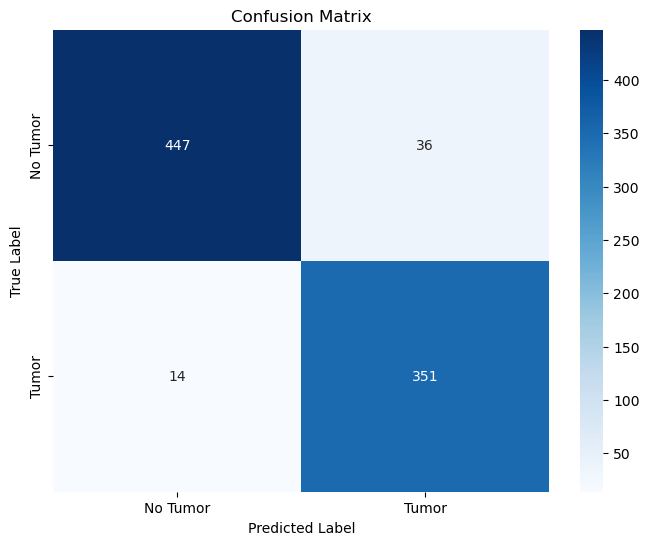

In [47]:
print(classification_report(y_true, y_pred))
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Tumor', 'Tumor'], yticklabels=['No Tumor', 'Tumor'])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [50]:
def predict_image(model, image):
    transform = transforms.Compose([
        transforms.Resize((256, 256)), 
        transforms.ToTensor(),  
    ])


    image = transform(image).unsqueeze(0)  
    image = image.to(device) 


    model.eval() 
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output.data, 1)  

    return predicted.item()

In [53]:
random_index = random.randint(0, len(dt['train']) - 1)
random_index

2312

In [54]:
random_example = ds['train'][random_index]
random_image = random_example['image']

In [55]:
predicted_label = predict_image(model, random_image)

In [56]:
predicted_result = "Обнаружена опухоль" if predicted_label == 1 else "Нет опухоли"
print(f"Результат для случайного изображения: {predicted_result}")

Результат для случайного изображения: Обнаружена опухоль


In [57]:
random_example['label']

1

In [58]:
torch.save(model.state_dict(), 'tumor_model.pth')

In [60]:
random_image.format

'PNG'

In [77]:
nii_file = r"C:\Users\dania\Downloads\archive\volume_pt4\volume-37.nii"
img = nib.load(nii_file)
data = img.get_fdata()


mid_slice = data.shape[2] // 2
slice_data = data[:, :, mid_slice]


plt.imshow(slice_data.T, cmap='gray', origin='lower')
plt.axis('off') 
plt.savefig('slice_37.png', bbox_inches='tight', pad_inches=0)
plt.close()

In [78]:
slice_path = r'slice_37.png'

In [79]:
slice_path

'slice_37.png'

In [80]:
predicted_label = predict_image(model, Image.open(slice_path).convert("RGB"))

In [81]:
predicted_label

1